# Final Project

This notebook is adapted from here: https://aiqm.github.io/torchani/examples/nnp_training.html

## Checkpoint 1: Data preparation

1. Create a working directory: `/global/scratch/users/[USER_NAME]/[DIR_NAME]`. Replace the [USER_NAME] with yours and specify a [DIR_NAME] you like.
2. Copy this Jupyter Notebook to the working directory
3. Download the ANI dataset `ani_dataset_gdb_s01_to_s04.h5` from bCourses and upload it to the working directory
4. Complete this notebook (can be worked on with your laptop, but **must be run on the cluster** for the final outputs)

Hint: You can use ? to learn more about any python function, e.g. ?torch.nn.Linear

In [1]:
!pwd

/global/scratch/users/jedrickzablan/jedrickzablan/final


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani
from torch.utils.data import DataLoader

### Use GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Set up AEV computer

#### AEV: Atomic Environment Vector (atomic features)

Ref: Chem. Sci., 2017, 8, 3192

In [4]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


### Prepare dataset & split

In [5]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")

In [6]:
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

# Show amount of training data vs total data
print(f'Total data amount: {len(dataset)}')
print(f'Training data amount: {len(train_data)}')                      
print(f'Validation data amount: {len(val_data)}')  
print(f'Testing data amount: {len(test_data)}')  

Total data amount: 864898
Training data amount: 691918
Validation data amount: 86489
Testing data amount: 86489


### Batching

In [7]:
batch_size = 8192
# use dataset.collate(...).cache() method to do batching
train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

In [8]:
# Show that batching is working correctly
def batch_check(data_loader):
    '''
    Iterates through the batch to display the list of tensors (species, coordinates, energies)
    
    data_loader: batch
        Batch of data that will be iterated through and printed (training, validation, testing)
    '''
    for data in data_loader:
        print(data)
        break

In [9]:
train_batch = batch_check(train_data_loader)

defaultdict(<class 'list'>, {'species': tensor([[ 1,  1,  1,  ...,  0, -1, -1],
        [ 2,  2,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ...,  0,  0, -1],
        ...,
        [ 2,  1,  1,  ..., -1, -1, -1],
        [ 2,  2,  0,  ..., -1, -1, -1],
        [ 1,  3,  1,  ..., -1, -1, -1]]), 'coordinates': tensor([[[ 1.2337, -0.6710,  0.1172],
         [-0.0060,  0.0674, -0.4338],
         [-1.2464, -0.7002,  0.0967],
         ...,
         [ 0.2381,  1.3170,  1.0117],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-1.0953,  0.1470, -0.1020],
         [ 0.0779, -0.5250,  0.0090],
         [ 1.1256,  0.1641,  0.0038],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 1.8722, -0.1366, -0.0445],
         [ 0.5224,  0.5569,  0.0346],
         [-0.5938, -0.5221,  0.0740],
         ...,
         [-1.9972,  1.0218,  0.4571],
         [-2.6581, -0.4425,  0.1587]

In [10]:
val_batch = batch_check(val_data_loader)

defaultdict(<class 'list'>, {'species': tensor([[ 1,  2,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1],
        [ 1,  1,  2,  ..., -1, -1, -1],
        ...,
        [ 3,  2,  1,  ..., -1, -1, -1],
        [ 2,  1,  1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1]]), 'coordinates': tensor([[[-1.7161e+00,  1.4846e-01, -8.5109e-03],
         [-4.0085e-01, -4.6554e-01, -4.4087e-03],
         [ 7.1840e-01,  3.7312e-01,  2.6289e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.8040e+00, -3.2883e-01,  4.5746e-01],
         [ 6.5510e-01,  2.5754e-01, -4.3580e-02],
         [-6.5509e-01, -3.9259e-01, -3.0877e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.2422e+00, -2.3173e-01, -6.5115e-02],
        

In [11]:
test_batch = batch_check(test_data_loader)

defaultdict(<class 'list'>, {'species': tensor([[ 1,  1,  2,  ...,  0,  0, -1],
        [ 1,  3,  1,  ..., -1, -1, -1],
        [ 2,  1,  1,  ..., -1, -1, -1],
        ...,
        [ 1,  1,  2,  ...,  0,  0, -1],
        [ 1,  1,  2,  ..., -1, -1, -1],
        [ 1,  3,  0,  ..., -1, -1, -1]]), 'coordinates': tensor([[[-1.5128,  0.5756, -0.0788],
         [-0.6410, -0.6432,  0.2976],
         [ 0.7191, -0.6961, -0.2725],
         ...,
         [ 1.3919,  0.7440,  1.1861],
         [ 2.5782,  0.3472, -0.1798],
         [ 0.0000,  0.0000,  0.0000]],

        [[-1.1958, -0.1534, -0.0228],
         [-0.0196,  0.5252, -0.0176],
         [ 1.2039, -0.1857,  0.0197],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 1.6055, -0.4820, -0.1018],
         [ 0.5946,  0.5603,  0.0127],
         [-0.8273,  0.0295, -0.0423],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]

### Torchani API

In [12]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torchani.ANIModel() to compile atomic networks
atom_net = [net_H, net_C, net_N, net_O]

ani_net = torchani.ANIModel(atom_net)
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [13]:
model

Sequential(
  (0): AEVComputer()
  (1): ANIModel(
    (0): AtomicNet(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (1): AtomicNet(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (2): AtomicNet(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (3): AtomicNet(
      (layers): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)

In [14]:
train_data_batch = next(iter(train_data_loader))

loss_func = nn.MSELoss()
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.1073, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
val_data_batch = next(iter(val_data_loader))

loss_func = nn.MSELoss()
species = val_data_batch['species'].to(device)
coords = val_data_batch['coordinates'].to(device)
true_energies = val_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.1060, device='cuda:0', grad_fn=<MseLossBackward0>)


In [16]:
test_data_batch = next(iter(test_data_loader))

loss_func = nn.MSELoss()
species = test_data_batch['species'].to(device)
coords = test_data_batch['coordinates'].to(device)
true_energies = test_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.1062, device='cuda:0', grad_fn=<MseLossBackward0>)


# Checkpoint 2: Network training
1. Append the codes in this notebook to Checkpoint 1
2. Fill out the ANITrainer class
3. Train a model to learn from 2 small datasets (1 heavy atom, and >1 heavy atoms)
- Play with the batch size and number of epochs
- Aim for RMSE (Root Mean Squared Error) to be less than 5 kcal/mol
4. Compare the time between running on CPU and GPU. Here's the suggested workflow
- Complete all the code on your laptop and run
- Rerun on Savio with GPU to see if the time improves

In [17]:
import matplotlib.pyplot as plt
import time

def timeit(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func: {f.__name__} took: {te-ts:.4f} sec on {device}')
        return result
    return timed

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay = l2)
        self.epoch = epoch
        # definition of loss function: MSE is a good choice! 
        self.loss_function = nn.MSELoss()
    
    @timeit
    def train(self, train_data, val_data, 
              early_stop=True, draw_curve=True, verbose=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()
        val_data_loader = val_data.collate(batch_size).cache()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        if verbose:
            iterator = range(self.epoch)
        else:
            iterator = tqdm(range(self.epoch), leave=True)
        
        for i in iterator:
            train_epoch_loss = 0.0
            # compute energies
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coordinates = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()

                batch_importance = species.shape[0] / len(val_data)
                
                self.optimizer.zero_grad()
                _, pred_energies = self.model((species, coordinates))
            
            # compute loss
                loss = self.loss_function(pred_energies, true_energies) * batch_importance
                loss.backward()
                
            # do a step
                self.optimizer.step()
                
                train_epoch_loss += loss.item() * batch_importance
                
            val_epoch_loss, mae, rmse = self.evaluate(val_data, draw_plot=False)     
            if verbose: 
                print(f'Epoch {i+1}: MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol')

            train_loss_list.append(train_epoch_loss / len(train_data_loader))
            val_loss_list.append(val_epoch_loss / len(val_data_loader))
            
            if early_stop and val_epoch_loss < lowest_val_loss:
                lowest_val_loss = val_epoch_loss
                weights = self.model.state_dict()
        
        if draw_curve:
            # Plot train loss and validation loss
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            # If you used MSELoss above to compute the loss
            # Calculate the RMSE for plotting
            epochs = np.arange(1, self.epoch + 1)
            train_rmse = [np.sqrt(loss) for loss in train_loss_list]
            val_rmse = [np.sqrt(loss) for loss in val_loss_list]
            
            ax.plot(epochs, train_rmse, label='Train')
            ax.plot(epochs, val_rmse, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("RMSE")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size).cache()
        total_loss = 0.0
        
        # init energies containers
        true_energies_all = []
        pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coordinates = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()

                batch_importance = species.shape[0] / len(data)

                # Predict energies using the model
                _, pred_energies = self.model((species, coordinates))

                # Compute loss
                loss = self.loss_function(pred_energies, true_energies) * batch_importance
                total_loss += loss.item() * batch_importance

                # store true and predicted energies
                true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten()) 
        true_energies_all = np.concatenate(true_energies_all)
        pred_energies_all = np.concatenate(pred_energies_all)

        # Report the mean absolute error (MAE) and root mean square error (RMSE)
        # The unit of energies in the dataset is hartree
        # please convert it to kcal/mol when reporting
        # 1 hartree = 627.5094738898777 kcal/mol
        # MAE = mean(|true - pred|)
        # RMSE = sqrt(mean( (true-pred)^2 ))
        hartree2kcalmol = 627.5094738898777
        mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol 
        rmse = np.sqrt(np.mean((true_energies_all - pred_energies_all) ** 2)) * hartree2kcalmol

        if draw_plot:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss, mae, rmse

## 1 heavy atom

Train/Total: 8640/864898
Sequential - Number of parameters: 197636


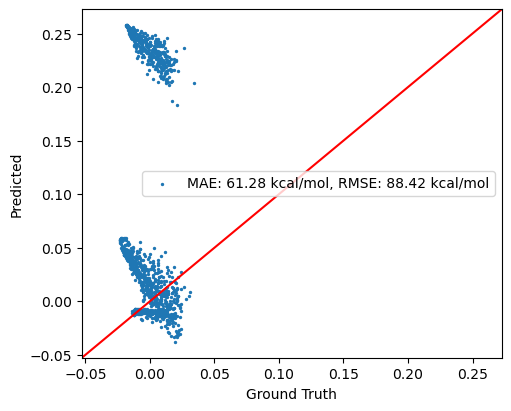

In [20]:
batch_size = 8192
epochs_count = 100

# Load dataset with 1 heavy atom
# Then do a train/val/test = 80/10/10 split
dataset_heavy = load_ani_dataset("./ani_gdb_s01.h5")
train_data, val_data, test_data = dataset_heavy.split(0.8, 0.1, 0.1)

print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model, batch_size, 1e-3, epochs_count, 1e-5)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: MAE: 82.97 kcal/mol, RMSE: 94.71 kcal/mol
Epoch 2: MAE: 21.38 kcal/mol, RMSE: 27.26 kcal/mol
Epoch 3: MAE: 38.22 kcal/mol, RMSE: 45.12 kcal/mol
Epoch 4: MAE: 55.10 kcal/mol, RMSE: 62.15 kcal/mol
Epoch 5: MAE: 42.56 kcal/mol, RMSE: 48.01 kcal/mol
Epoch 6: MAE: 23.11 kcal/mol, RMSE: 30.28 kcal/mol
Epoch 7: MAE: 26.17 kcal/mol, RMSE: 30.55 kcal/mol
Epoch 8: MAE: 26.00 kcal/mol, RMSE: 32.35 kcal/mol
Epoch 9: MAE: 20.07 kcal/mol, RMSE: 25.33 kcal/mol
Epoch 10: MAE: 15.64 kcal/mol, RMSE: 19.64 kcal/mol
Epoch 11: MAE: 19.56 kcal/mol, RMSE: 24.39 kcal/mol
Epoch 12: MAE: 22.54 kcal/mol, RMSE: 26.61 kcal/mol
Epoch 13: MAE: 16.83 kcal/mol, RMSE: 20.22 kcal/mol
Epoch 14: MAE: 9.19 kcal/mol, RMSE: 11.31 kcal/mol
Epoch 15: MAE: 9.51 kcal/mol, RMSE: 12.62 kcal/mol
Epoch 16: MAE: 13.58 kcal/mol, RMSE: 16.52 kcal/mol
Epoch 17: MAE: 12.28 kcal/mol, RMSE: 14.95 kcal/mol
Epoch 18: MAE: 9.22 kcal/mol, RMSE: 11.30 kcal/mol
Epoch 19: MAE: 9.10 kcal/mol, RMSE: 11.31 kcal/m

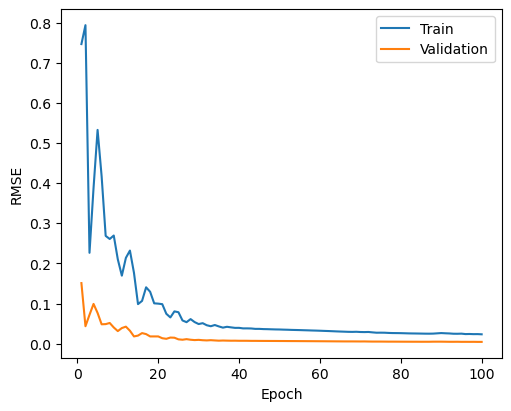

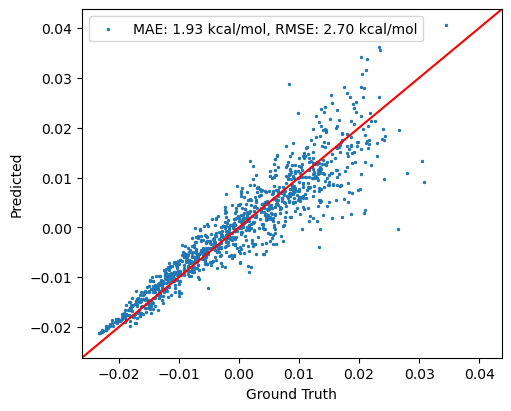

In [21]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: MAE: 1.98 kcal/mol, RMSE: 2.78 kcal/mol
Epoch 2: MAE: 2.01 kcal/mol, RMSE: 2.75 kcal/mol
Epoch 3: MAE: 1.91 kcal/mol, RMSE: 2.74 kcal/mol
Epoch 4: MAE: 1.93 kcal/mol, RMSE: 2.71 kcal/mol
Epoch 5: MAE: 1.96 kcal/mol, RMSE: 2.72 kcal/mol
Epoch 6: MAE: 1.92 kcal/mol, RMSE: 2.70 kcal/mol
Epoch 7: MAE: 1.91 kcal/mol, RMSE: 2.69 kcal/mol
Epoch 8: MAE: 1.92 kcal/mol, RMSE: 2.68 kcal/mol
Epoch 9: MAE: 1.92 kcal/mol, RMSE: 2.68 kcal/mol
Epoch 10: MAE: 1.93 kcal/mol, RMSE: 2.67 kcal/mol
Epoch 11: MAE: 1.95 kcal/mol, RMSE: 2.74 kcal/mol
Epoch 12: MAE: 2.10 kcal/mol, RMSE: 2.80 kcal/mol
Epoch 13: MAE: 2.17 kcal/mol, RMSE: 3.03 kcal/mol
Epoch 14: MAE: 2.38 kcal/mol, RMSE: 3.07 kcal/mol
Epoch 15: MAE: 2.29 kcal/mol, RMSE: 3.16 kcal/mol
Epoch 16: MAE: 2.33 kcal/mol, RMSE: 2.91 kcal/mol
Epoch 17: MAE: 2.19 kcal/mol, RMSE: 2.98 kcal/mol
Epoch 18: MAE: 2.10 kcal/mol, RMSE: 2.76 kcal/mol
Epoch 19: MAE: 1.89 kcal/mol, RMSE: 2.62 kcal/mol
Epoch 20: MAE: 1.87 kcal/mol, R

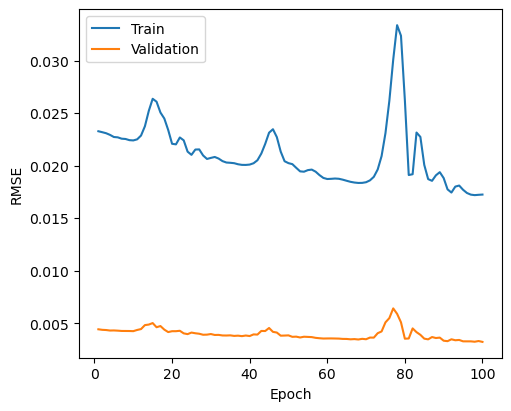

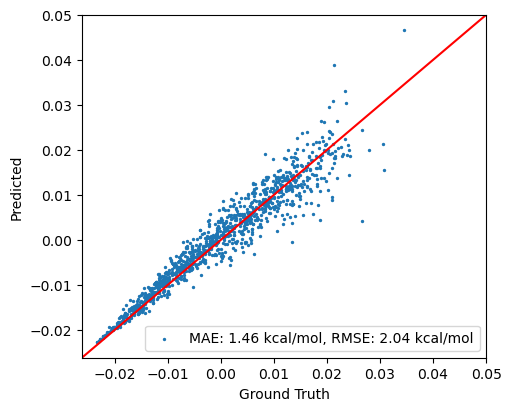

In [22]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

## n heavy atoms

Train/Total: 40769/864898
Train/Total: 40769/864898
Sequential - Number of parameters: 197636


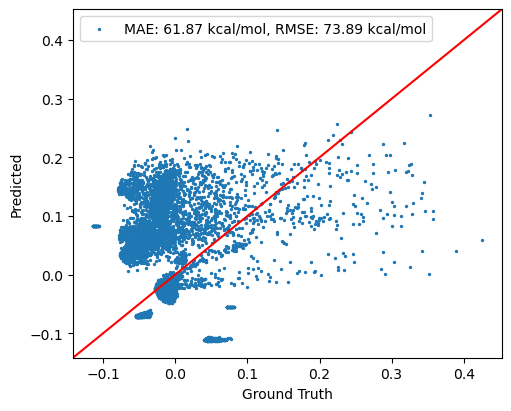

In [23]:
batch_size = 8192
epochs_count = 100

# Load dataset with n (different from 1) heavy atom
# Then do a train/val/test = 80/10/10 split
dataset_heavy = load_ani_dataset("./ani_gdb_s02.h5")
train_data, val_data, test_data = dataset_heavy.split(0.8, 0.1, 0.1)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')


print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model, batch_size, 1e-3, epochs_count, 1e-5)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: MAE: 43.83 kcal/mol, RMSE: 54.12 kcal/mol
Epoch 2: MAE: 26.59 kcal/mol, RMSE: 35.92 kcal/mol
Epoch 3: MAE: 20.50 kcal/mol, RMSE: 26.07 kcal/mol
Epoch 4: MAE: 15.11 kcal/mol, RMSE: 21.41 kcal/mol
Epoch 5: MAE: 11.00 kcal/mol, RMSE: 17.86 kcal/mol
Epoch 6: MAE: 10.96 kcal/mol, RMSE: 16.70 kcal/mol
Epoch 7: MAE: 9.55 kcal/mol, RMSE: 15.47 kcal/mol
Epoch 8: MAE: 9.28 kcal/mol, RMSE: 14.69 kcal/mol
Epoch 9: MAE: 7.95 kcal/mol, RMSE: 13.46 kcal/mol
Epoch 10: MAE: 7.29 kcal/mol, RMSE: 12.41 kcal/mol
Epoch 11: MAE: 6.88 kcal/mol, RMSE: 11.77 kcal/mol
Epoch 12: MAE: 6.52 kcal/mol, RMSE: 11.18 kcal/mol
Epoch 13: MAE: 6.21 kcal/mol, RMSE: 10.67 kcal/mol
Epoch 14: MAE: 5.92 kcal/mol, RMSE: 10.22 kcal/mol
Epoch 15: MAE: 5.71 kcal/mol, RMSE: 9.83 kcal/mol
Epoch 16: MAE: 5.47 kcal/mol, RMSE: 9.42 kcal/mol
Epoch 17: MAE: 5.23 kcal/mol, RMSE: 9.05 kcal/mol
Epoch 18: MAE: 5.05 kcal/mol, RMSE: 8.68 kcal/mol
Epoch 19: MAE: 4.89 kcal/mol, RMSE: 8.36 kcal/mol
Epoch 20: M

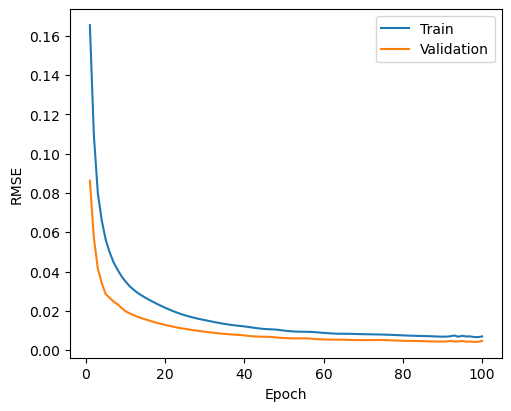

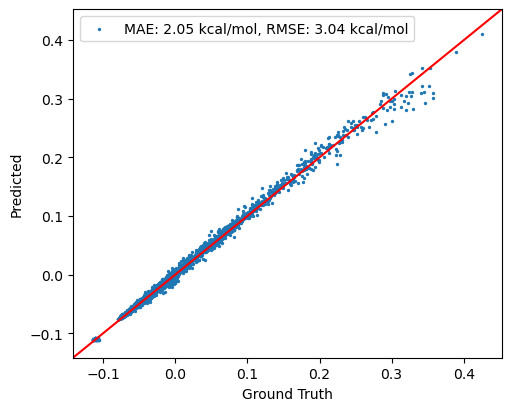

In [24]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
Epoch 1: MAE: 1.67 kcal/mol, RMSE: 2.69 kcal/mol
Epoch 2: MAE: 1.65 kcal/mol, RMSE: 2.66 kcal/mol
Epoch 3: MAE: 2.15 kcal/mol, RMSE: 3.01 kcal/mol
Epoch 4: MAE: 1.57 kcal/mol, RMSE: 2.56 kcal/mol
Epoch 5: MAE: 1.71 kcal/mol, RMSE: 2.71 kcal/mol
Epoch 6: MAE: 1.67 kcal/mol, RMSE: 2.60 kcal/mol
Epoch 7: MAE: 1.56 kcal/mol, RMSE: 2.53 kcal/mol
Epoch 8: MAE: 1.55 kcal/mol, RMSE: 2.54 kcal/mol
Epoch 9: MAE: 1.99 kcal/mol, RMSE: 2.84 kcal/mol
Epoch 10: MAE: 2.11 kcal/mol, RMSE: 3.12 kcal/mol
Epoch 11: MAE: 1.76 kcal/mol, RMSE: 2.72 kcal/mol
Epoch 12: MAE: 1.59 kcal/mol, RMSE: 2.51 kcal/mol
Epoch 13: MAE: 1.83 kcal/mol, RMSE: 2.69 kcal/mol
Epoch 14: MAE: 1.51 kcal/mol, RMSE: 2.46 kcal/mol
Epoch 15: MAE: 1.59 kcal/mol, RMSE: 2.55 kcal/mol
Epoch 16: MAE: 1.80 kcal/mol, RMSE: 2.66 kcal/mol
Epoch 17: MAE: 1.51 kcal/mol, RMSE: 2.47 kcal/mol
Epoch 18: MAE: 1.48 kcal/mol, RMSE: 2.42 kcal/mol
Epoch 19: MAE: 1.67 kcal/mol, RMSE: 2.54 kcal/mol
Epoch 20: MAE: 2.32 kcal/mol, R

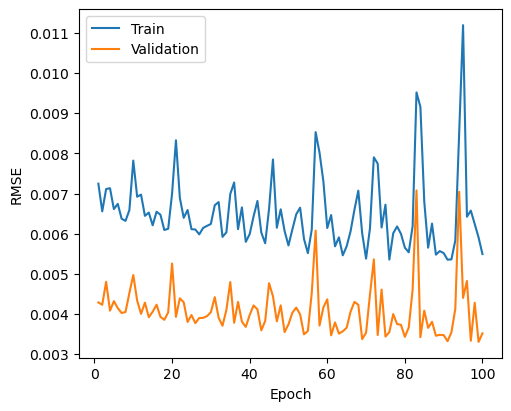

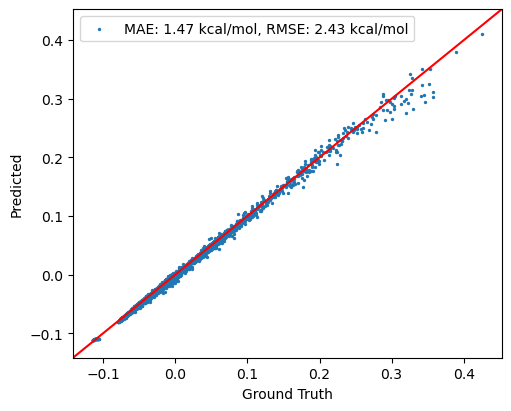

In [25]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

### The use of the GPU improves performance for 1 heavy atom and multiple heavy atoms. For 1 heavy atom, the GPU trained on the model in 4.1545 seconds while the CPU trained on the model in 22.5162 seconds. For multiple heavy atoms, the GPU trained on the model in 19.3704  seconds while the CPU trained on the model in 157.0355 seconds. All runs had a RMSE that was less than 5 kcal/mol. 

# Checkpoint 3: Architecture, hyperparameters and regularization

1. A couple of modifications
- To track the RMSE, add

```if verbose: print(f'Epoch {i+1}: , MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol``` 

after this line

``` val_epoch_loss, mae, rmse = self.evaluate(val_data) ```
            
- If you see that the RMSE in your loss plot doesn't match your, you probably haven't converted it to the right unit. Hint: use ``` hartree2kcalmol = 627.5094738898777 ```

- A bug from checkpoint 2: model/ani_net/net_H/... are not correctly re-defined before training on a new dataset. See below for fix.

2. Play with the architecture, hyperparameters, and regularization strategies. Use an n-heavy-atom data (s02, s03, or s04). With the model defined in checkpoint 1, here are the ROUGH approximate runtimes on Savio's GPU for different data sets:
- s02: 65 sec
- s03: 229 sec
- s04: 1256 sec
- s01_to_s04: 1548 sec

3. Do a run with the full dataset (s01_to_s04). Test the trained model on each smaller dataset and write down your observation.

## Full data set
Note that you need to redefine the model (net_H, etc.) everytime to ensure that you are reseting everything before training on a new dataset

Train/Total: 691918/864898
Sequential - Number of parameters: 197636


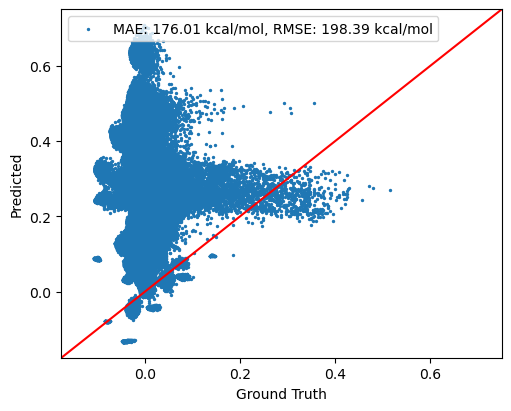

In [21]:
# Then do a train/val/test = 80/10/10 split
dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8,0.1,None)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)


# Initiate the trainer and evaluate on test_dataset with draw_plot=True
batch_size = 10000
epochs_count = 100

trainer = ANITrainer(model, batch_size, 1e-3, epochs_count, 1e-9)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...


100%|██████████| 100/100 [17:18<00:00, 10.38s/it]


func: train took: 1064.5098 sec on cuda


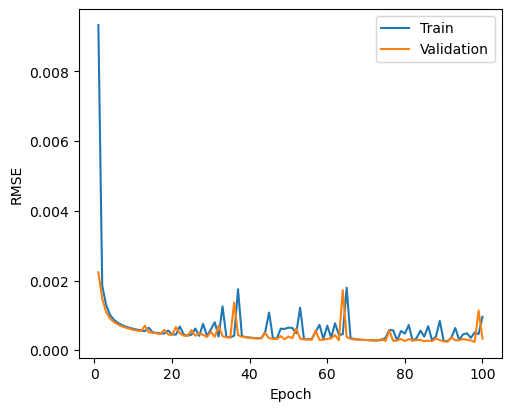

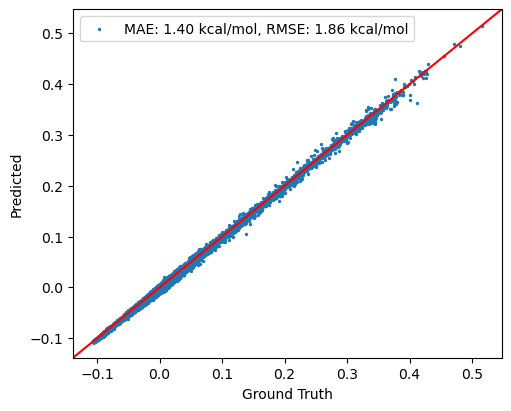

In [22]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=False)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Test model trained on s01_to_s04 on s01 data
Test model trained on s01_to_s04 on s02 data
Test model trained on s01_to_s04 on s03 data
Test model trained on s01_to_s04 on s04 data


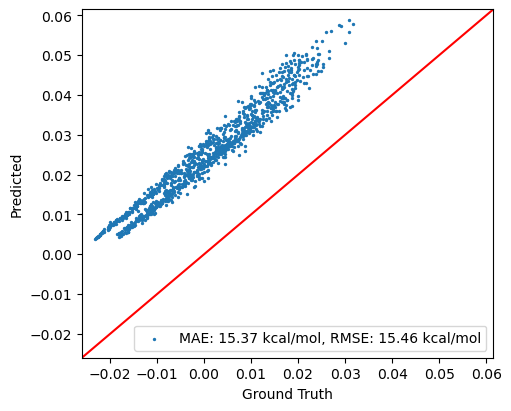

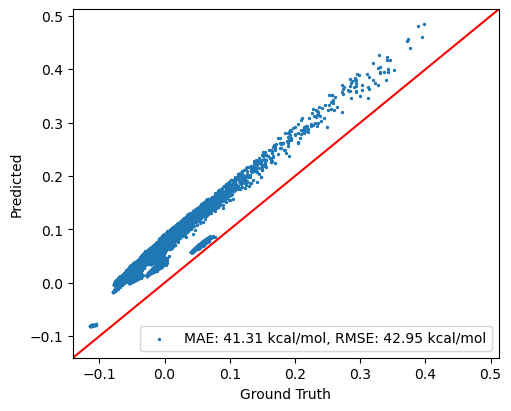

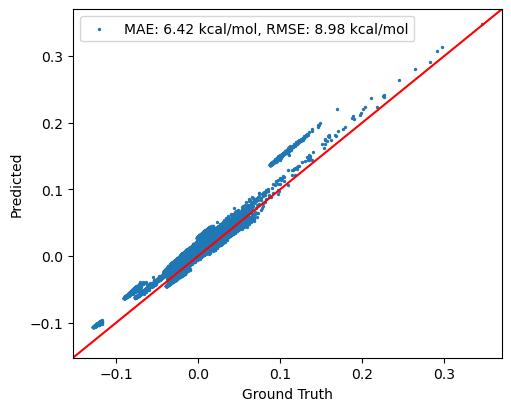

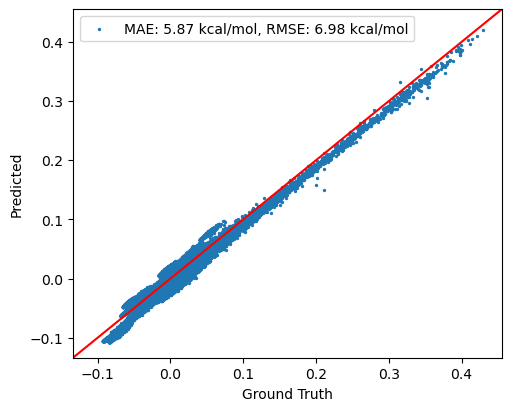

In [23]:
for i in range(1,5):
    print(f'Test model trained on s01_to_s04 on s0{i} data')
    dataset = load_ani_dataset(f"./ani_gdb_s0{i}.h5")
    train_data, val_data, test_data = dataset.split(0.8,0.1,None)
    loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

#### I tried out different hyperparameters to improve the RMSE and MAE of my model. I also implemented edits to my architecture from Checkpoint 2's feedback. First, I used a baseline of 8192 batch size and 100 epoch which achieved an RMSE of 4.26 kcal/mol in 1010.1861 seconds which was above the desired 3 kcal/mol. I then tested different hyperparameters to see what would help in achieving a lower RMSE.

#### When I lowered the epoch to 50, the RMSE slightly increased to 4.35 kcal/mol RMSE. Although this reduced the run time by half, it slightly increased the RMSE to 4.35 kcal/mol. When I increased the batch size to 10000, the RMSE was lowered to 3.78 kcal/mol. After this, I observed that the points were underfitting, so I sought to see what I could do to reduce the MSE by changing the learning rate and/or regularization. 

#### Using a batch size of 10000, I first tried changing the learning rate. Increasing the learning rate to 0.1 increased the RMSE to 17.38 and decreasing the learning rate to 1e-5 increased the RMSE to 5.62 kcal/mol. 

#### Using a batch size of 10000, I decreased the regularization because that would aid in underfitting. When increasing the regularization to 1e-7, the learning rate slightly increased to 4.98 kcal/mol. I further investigated by decreasing the regularization even more to 1e-9 which yielded an acceptable 1.46 kcal/mol RMSE and a 1.05 kcal/mol MAE with a run time of 1064.5098 seconds. For insurance, I also tested increasing the regularization which expectly greatly increased the RMSE to 18.12 kcal/mol.

#### Lowering in the epoch to 50 while keeping the other hyperparameters also results in an acceptable RMSE and MAE of 1.89 kcal/mol and 1.37 kcal/mol respectively with a run time of 525.7112 seconds. However, this is an increase from using 100 epoch. Therefore, to maintain the lowest MAE and RMSE possible, the optimal parameters for the trainer are a batch size of 10000, learning rate of 1e-3, epoch of 100 and a l2 regularization of 1e-9. 